# Recursion Cellular Image Classification
### CellSignal: Disentangling biological signal from experimental noise in cellular images

> **Work done by**: Nwachukwu Anthony  
> **Email**: nwachukwuanthony2015@gmail.com  
> **Inspired by**: *Fastai online courses on Deep Learning*  
> **Data from kaggle** competition, link below

The cost of some drugs and medical treatments has risen so high in recent years that many patients are having to go without. You can help with a classification project that could make researchers more efficient.

One of the more surprising reasons behind the cost is how long it takes to bring new treatments to market. Despite improvements in technology and science, research and development continues to lag. In fact, finding new treatments takes, on average, more than 10 years and costs hundreds of millions of dollars.

Recursion Pharmaceuticals, creators of the industry’s largest dataset of biological images, generated entirely in-house, believes AI has the potential to dramatically improve and expedite the drug discovery process. More specifically, your efforts could help them understand how drugs interact with human cells.

This will have you disentangling experimental noise from real biological signals. Your entry will classify images of cells under one of 1,108 different genetic perturbations. You can help eliminate the noise introduced by technical execution and environmental variation between experiments.

If successful, you could dramatically improve the industry’s ability to model cellular images according to their relevant biology. In turn, applying AI could greatly decrease the cost of treatments, and ensure these treatments get to patients faster.


You will find the dataset on this website: https://www.kaggle.com/c/recursion-cellular-image-classification/data

### Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np 
import pandas as pd
from fastai.metrics import accuracy
from fastai.vision import *
import os
print(os.listdir("../input/recursion-cellular-image-classification"))

['train_controls.csv', 'train', 'test', 'recursion_dataset_license.pdf', 'pixel_stats.csv', 'train.csv', 'sample_submission.csv', 'test.csv', 'test_controls.csv']


### Set the paths and Prepare the data

In [2]:
path = '../input/recursion-cellular-image-classification'
dftrain = pd.read_csv(path+'/train.csv')
dftrain = dftrain[['id_code','sirna']]

i = 0
dic = {}
dictest = {}
for fold1 in os.listdir(path+'/train'):
    for fold2 in os.listdir(path+'/train/'+fold1):
        for image in os.listdir(path+'/train/'+fold1+'/'+fold2):
            dic[str(fold1)+'_'+fold2[5:]+'_'+image[0:3]] = str(fold1)+'/'+fold2+'/'+image
df = pd.DataFrame(list(dic.items()), columns=['id_code','Item'])
dftraindf = pd.merge(df, dftrain)
trainData = dftraindf[['Item','sirna']]
#df = df.astype({"a": int, "b": complex})
#trainData = trainData.astype({'sirna': str})
trainData.to_csv(r'../working/trainData.csv', index = None, header=True);
#print(pd. read_csv ('../working/trainData.csv'))


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
path = '../input/recursion-cellular-image-classification'
dftest = pd.read_csv(path+'/test.csv')
dftest = dftest['id_code']
i = 0
dictest = {}
for fold1 in os.listdir(path+'/test'):
    for fold2 in os.listdir(path+'/test/'+fold1):
        for image in os.listdir(path+'/test/'+fold1+'/'+fold2):
            dictest[str(fold1)+'_'+fold2[5:]+'_'+image[0:3]] = str(fold1)+'/'+fold2+'/'+image
df = pd.DataFrame(list(dictest.items()), columns=['id_code','foldPath'])
"""dftraindf = pd.merge(df, dftest)
testData = dftraindf[['Item']]"""
df.to_csv(r'../working/testData.csv', index = None, header=True);
#print(pd. read_csv ('../working/testData.csv'))
#print(df.head())

In [4]:
tfms = get_transforms()
#df = pd.read_csv(path/'labels.csv', header='infer')
#path = Path(path)
# Set the parameters and create the data for the model
np.random.seed(42) #makes sure you get same results each time you run the code
src = (ImageList.from_csv('../', 'working/trainData.csv', folder='input/recursion-cellular-image-classification/train')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))
tfms = get_transforms()
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))



#data = ImageDataBunch.from_df('../','working/trainData.csv',folder=path+'/train', ds_tfms=tfms, size=128)

In [5]:
# Since kaggle doesn't allow write on the iput directory, we create a new directory outside it where
# we can freely work and make it the path
#path = Path("../working")
#path

### Visualize the Data

In [6]:
#img = open_image(path+'/train/HEPG2-04/Plate1/O23_s2_w4.png')
#img

In [7]:
#trainData
#trainData.loc[trainData['sirna'] == 810]
#len(data.classes)

(29212, 7303)


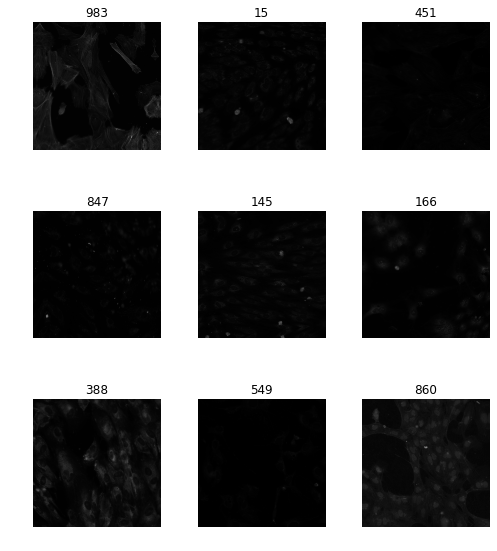

In [8]:
#print(data.classes)
print((len(data.train_ds),len(data.valid_ds)))
data.show_batch(rows=3, figsize=(7,8)) #View portion of dataset

### Tain

In [9]:
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs.long()).float().mean()

"""From https://www.kaggle.com/leighplt/densenet121-pytorch"""
def accuracy1(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return torch.Tensor(np.array(res))

In [10]:
#Set the metrics. Use F-score
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)
#Use CNN (Convolutional Neural Network) and pretrained model (resnet50)  to train
#learn = cnn_learner(data, models.resnet50, metrics=[acc_02,f_score])
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.8MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


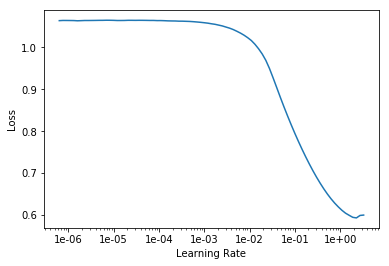

In [11]:
#Find and plot learning rate
learn.lr_find()
learn.recorder.plot()

In [12]:
#set learning rate
lr = 0.05

In [13]:
#Fit the model
learn.fit_one_cycle(5,slice(lr))#5

epoch,train_loss,valid_loss,accuracy,time
0,0.009587,0.009426,0.000000,05:45
1,0.008099,0.007840,0.000000,05:35
2,0.007994,0.192213,0.000000,05:38
3,0.007504,0.007455,0.000000,05:37
4,0.007242,0.009007,0.000000,05:42


In [14]:
# Save it
learn.save('stage-1-rn50')

In [15]:
####learn.load('stage-1-rn50');

### More training

In [16]:

# Unfreeze the model, that is, traing afresh without the pretrained model
learn.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


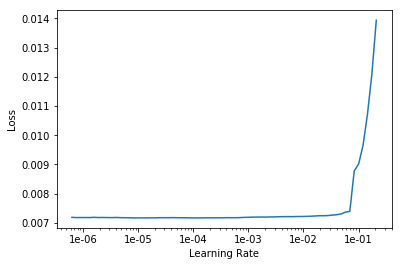

In [17]:
# Find and plot the learning rate
learn.lr_find()
learn.recorder.plot()

In [18]:
# Fit the model
learn.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.007190,0.027537,0.000000,05:44
1,0.007203,0.012628,0.000000,05:45
2,0.007174,0.009454,0.000000,05:45
3,0.007159,0.044386,0.000000,05:49
4,0.007159,0.021355,0.000000,05:48


In [19]:
# Save this latest trained model
learn.save('stage-2-rn50')

In [20]:
# Create a new dataset with batch size = 256
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
# Set the learners data as data
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


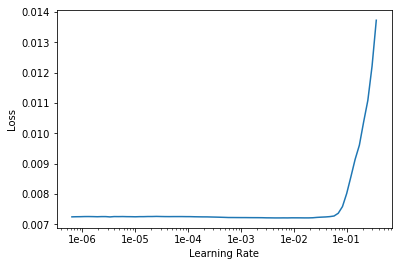

In [21]:
# Freeze and find learning rate
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [22]:
# Fit and save the model
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-256-rn50')

epoch,train_loss,valid_loss,accuracy,time
0,0.007226,0.015284,0.000000,07:26
1,0.007245,0.014524,0.000000,07:23
2,0.007193,0.032012,0.000000,07:27
3,0.007122,0.055155,0.000958,07:25
4,0.007071,0.099804,0.000000,07:27


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


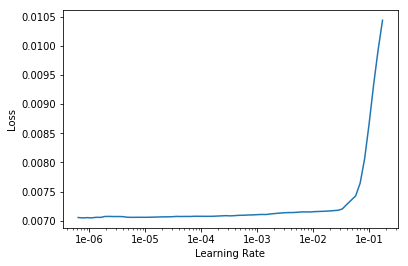

In [23]:
# Freeze and find learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
# Fit and save the model
learn.fit_one_cycle(10, slice(2e-5, 4e-5))
learn.recorder.plot_losses()
learn.save('stage-2-256-rn50')

epoch,train_loss,valid_loss,accuracy,time
0,0.007055,0.081612,0.000000,07:44
1,0.007063,0.019913,0.000000,07:48
2,0.007052,0.363045,0.000000,07:38
3,0.007064,0.019211,0.000000,07:42
4,0.007041,0.322603,0.000000,07:44
5,0.007023,0.034178,0.000000,07:46
6,0.007016,0.008513,0.000137,07:47


In [25]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5, lr/5))
learn.save('stage-3-256-rn50')

epoch,train_loss,valid_loss,accuracy,time
0,0.007012,0.044177,0.000000,08:28
1,0.007037,1.206681,0.000000,08:23
2,0.007057,0.007134,0.000000,08:21
3,0.007034,0.029943,0.000000,08:16
4,0.007014,0.035985,0.000000,08:24
5,0.006966,0.026629,0.000410,08:29
6,0.006921,0.037912,0.000000,08:27


### Export the Model

In [26]:
learn.export()

### Test the Model

In [27]:
test = ImageList.from_csv('../', 'working/testData.csv', cols='foldPath', folder='input/recursion-cellular-image-classification/test')
learn = load_learner('../', test=test)

In [28]:
# Find the prediction
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
labelled_preds = [learn.data.classes[(pred).tolist().index(max((pred).tolist()))] for pred in preds]
#Althernatively, you can replace line two with these two lines of code below
#labels = np.argmax(preds, 1)
#labelled_preds = [data.classes[int(x)] for x in labels]
#print(labelled_preds)

In [29]:
lsttest = []
for item in learn.data.test_ds.items:
    lst = item.split('/')[-3:]
    lsttest.append(str(lst[0])+'_'+lst[1][5:]+'_'+lst[-1].split('_')[0])
df = pd.DataFrame(lsttest, columns=['id_code'])
#print(df.head())

In [30]:
path = '../input/recursion-cellular-image-classification'
dftestcsv = pd.read_csv(path+'/test.csv')

tes = OrderedDict([('id_code',lsttest), ('sirna', labelled_preds)] )
df = pd.DataFrame.from_dict(tes)

dftestcsv = pd.DataFrame(list(dftestcsv['id_code']), columns=['id_code'])
dftestdfcsv = pd.merge(dftestcsv, df)
dftestdfcsv.to_csv('../working/submission.csv', index=False)

In [31]:
dftestdfcsv.tail()

,id_code,sirna
19892,U2OS-05_4_O19,750
19893,U2OS-05_4_O20,380
19894,U2OS-05_4_O21,563
19895,U2OS-05_4_O22,232
19896,U2OS-05_4_O23,301


Thank you